# Predikcija plata u ekonomski razvijenim državama

**Autori:** Katarina Perović E2 131/2024, Milica Petrović E2 124/2024, Ana Radovanović E2 158/2024

**Predmet:** SIAP 

**1.Uvoz biblioteka**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys  
!{sys.executable} -m pip install seaborn

import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from IPython.display import display
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from skopt import BayesSearchCV


[notice] A new release of pip is available: 23.3.1 -> 25.3
[notice] To update, run: C:\Users\Katarina\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


## 2. Učitavanje, osnovna analiza i vizualizacija podataka

In [2]:
df = pd.read_csv("Salary.csv")
df.head()
df.info()
df[["Age", "Years of Experience", "Salary"]].describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6704 entries, 0 to 6703
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           6704 non-null   int64  
 1   Age                  6702 non-null   float64
 2   Gender               6702 non-null   object 
 3   Education Level      6701 non-null   object 
 4   Job Title            6702 non-null   object 
 5   Years of Experience  6701 non-null   float64
 6   Salary               6699 non-null   float64
 7   Country              6704 non-null   object 
 8   Race                 6704 non-null   object 
dtypes: float64(3), int64(1), object(5)
memory usage: 471.5+ KB


,Age,Years of Experience,Salary
count,6702.000000,6701.000000,6699.000000
mean,33.620859,8.094687,115326.964771
std,7.614633,6.059003,52786.183911
min,21.000000,0.000000,350.000000
25%,28.000000,3.000000,70000.000000
50%,32.000000,7.000000,115000.000000
75%,38.000000,12.000000,160000.000000
max,62.000000,34.000000,250000.000000


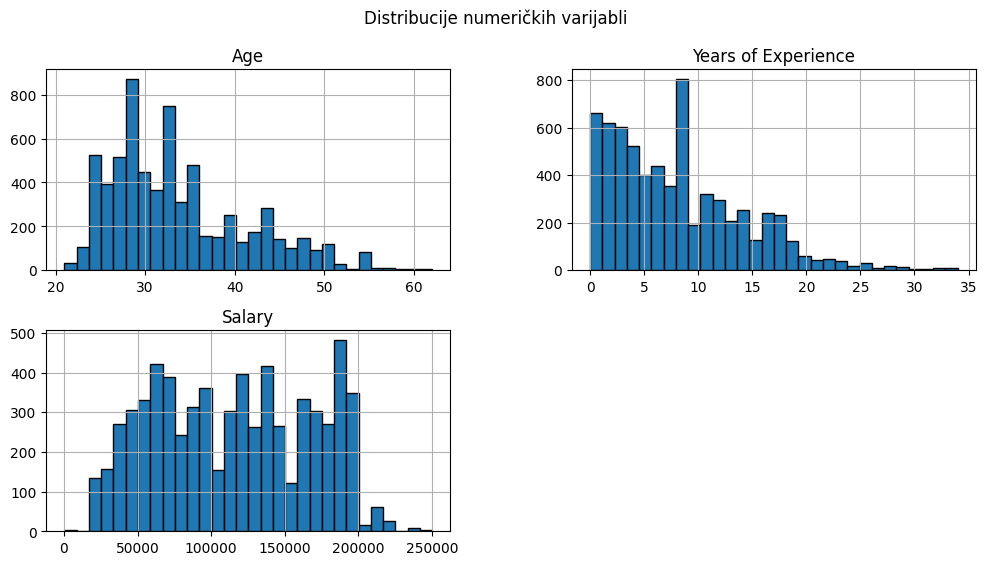

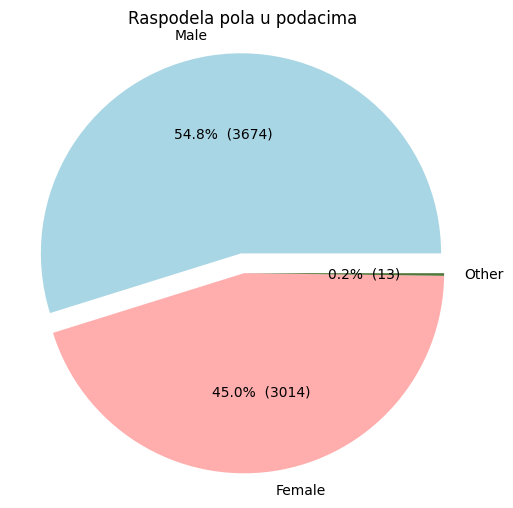

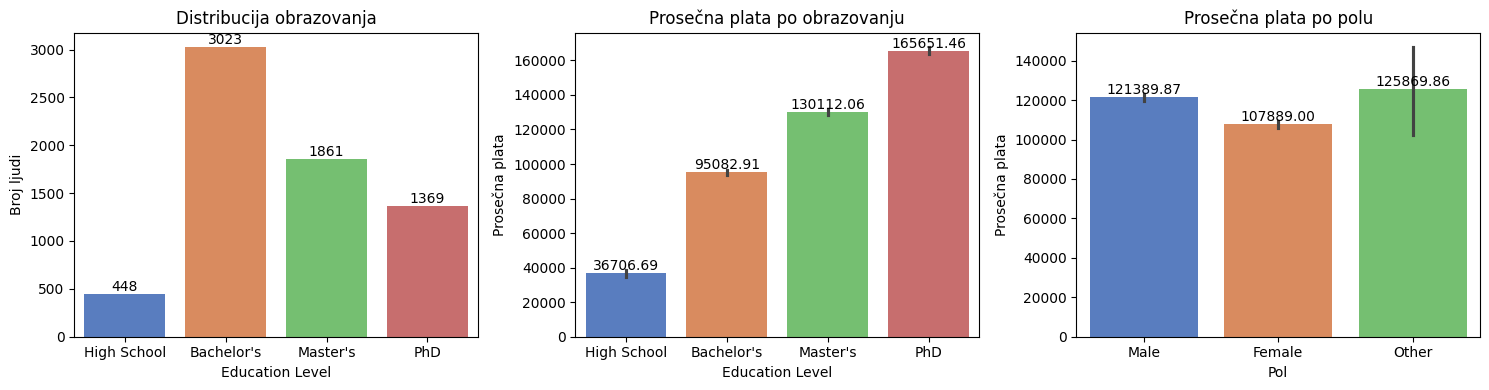

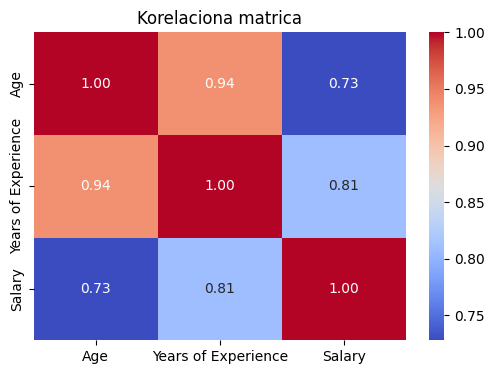

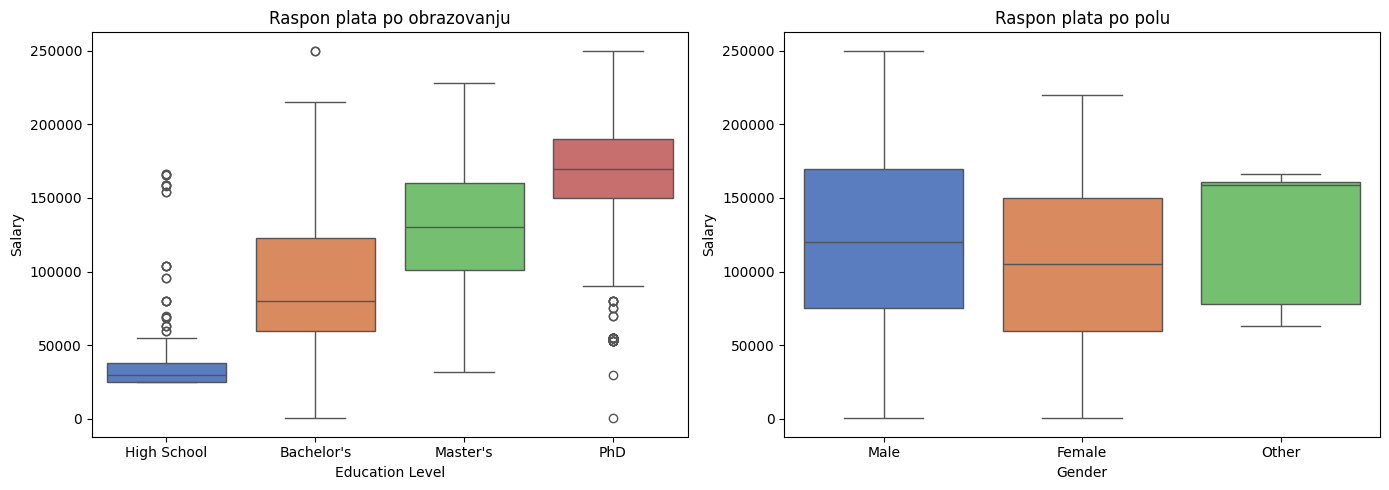

In [3]:
df["Education Level"] = df["Education Level"].replace(
    ["Bachelor's Degree", "Master's Degree", "phD"],
    ["Bachelor's", "Master's", "PhD"]
)

edu_order = ["High School", "Bachelor's", "Master's", "PhD"]
df["Education Level"] = pd.Categorical(
    df["Education Level"], 
    categories=edu_order, 
    ordered=True
)

num_cols = ["Age", "Years of Experience", "Salary"]
df[num_cols].hist(bins=30, figsize=(12,6), edgecolor="black")
plt.suptitle("Distribucije numeričkih varijabli")
plt.show()


gender_counts = df["Gender"].value_counts()

color_map = {
    "Male": "#A9D6E5",    
    "Female": "#FFADAD",  
    "Other": "#527539"    
}

colors = [color_map.get(g, "#D3D3D3") for g in gender_counts.index]  

explode = [0.1 if i == gender_counts.idxmax() else 0 for i in gender_counts.index]

plt.figure(figsize=(6, 6))
plt.pie(
    gender_counts,
    labels=gender_counts.index,
    colors=colors,
    autopct=lambda p: f'{p:.1f}%  ({int(p * sum(gender_counts) / 100)})',
    explode=explode
)
plt.axis("equal")
plt.title("Raspodela pola u podacima")
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(15, 4)) 

sns.countplot(
    x="Education Level", hue="Education Level", data=df, 
    order=edu_order, legend=False,
    palette="muted", ax=axes[0]
)
axes[0].set_title("Distribucija obrazovanja")
axes[0].set_xlabel("Education Level")
axes[0].set_ylabel("Broj ljudi")

for p in axes[0].patches:
    axes[0].annotate(
        f'{int(p.get_height())}', 
        (p.get_x() + p.get_width() / 2., p.get_height()), 
        ha='center', va='bottom'
    )

sns.barplot(
    x="Education Level", y="Salary", hue="Education Level", data=df,
    estimator="mean", order=edu_order, legend=False,
    palette="muted", ax=axes[1]
)
axes[1].set_title("Prosečna plata po obrazovanju")
axes[1].set_xlabel("Education Level")
axes[1].set_ylabel("Prosečna plata")

for p in axes[1].patches:
    value = p.get_height()
    axes[1].annotate(
        f'{value:.2f}',   
        (p.get_x() + p.get_width() / 2., value), 
        ha='center', va='bottom'
    )

sns.barplot(
    x="Gender", y="Salary", hue="Gender", data=df,
    estimator="mean", legend=False,
    palette="muted", ax=axes[2]
)
axes[2].set_title("Prosečna plata po polu")
axes[2].set_xlabel("Pol")
axes[2].set_ylabel("Prosečna plata")

for p in axes[2].patches:
    value = p.get_height()
    axes[2].annotate(
        f'{value:.2f}',
        (p.get_x() + p.get_width() / 2., value), 
        ha='center', va='bottom'
    )


plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
corr = df[["Age", "Years of Experience", "Salary"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Korelaciona matrica")
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(14, 5)) 

sns.boxplot(
    x="Education Level", y="Salary", hue="Education Level",
    data=df, order=edu_order, legend=False,
    palette="muted", ax=axes[0]
)
axes[0].set_title("Raspon plata po obrazovanju")

sns.boxplot(
    x="Gender", y="Salary", hue="Gender",
    data=df, legend=False,
    palette="muted", ax=axes[1]
)
axes[1].set_title("Raspon plata po polu")

plt.tight_layout()
plt.show()



## 3. Pretprocesiranje podataka

In [4]:
df = df.dropna()
df = df[~(df["Gender"] == "Other")]
df = df.drop(columns=["Race", "Country"], errors="ignore")

print("Broj redova pre izbacivanja outliera za platu:", len(df))
lower = df["Salary"].quantile(0.01)
upper = df["Salary"].quantile(0.99)
df = df[(df["Salary"] >= lower) & (df["Salary"] <= upper)]
print("Broj redova nakon izbacivanja outliera:", len(df))


print("Broj redova pre izbacivanja retkih poslova:", len(df))
print("Ukupno različitih poslova pre:", df["Job Title"].nunique())

job_counts = df["Job Title"].value_counts()
df = df[df["Job Title"].isin(job_counts[job_counts >= 50].index)]

print("Broj redova nakon izbacivanja retkih poslova:", len(df))
print("Ukupno različitih poslova posle:", df["Job Title"].nunique())


X = df.drop(columns=["Salary"])
y = df["Salary"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)


y_train_log = np.log1p(y_train)
y_valid_log = np.log1p(y_valid)
y_test_log  = np.log1p(y_test)


gender_col = ["Gender"]
edu_col = ["Education Level"]
job_col = ["Job Title"]

edu_order = [["High School", "Bachelor's", "Master's", "PhD"]]


preprocessor = ColumnTransformer(
    transformers=[
        ('edu', OrdinalEncoder(categories=edu_order), edu_col),
        ('gender', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), gender_col),
        ('job', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), job_col)
    ],
    remainder='passthrough'  
)

pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('scaler', StandardScaler())
])

X_train_scaled = pipeline.fit_transform(X_train)
X_valid_scaled = pipeline.transform(X_valid)
X_test_scaled  = pipeline.transform(X_test)


Broj redova pre izbacivanja outliera za platu: 6684
Broj redova nakon izbacivanja outliera: 6624
Broj redova pre izbacivanja retkih poslova: 6624
Ukupno različitih poslova pre: 188
Broj redova nakon izbacivanja retkih poslova: 5777
Ukupno različitih poslova posle: 38


## 4. KNN

In [5]:
#knn

param_grid = {
    'n_neighbors': [5, 10, 15, 20, 30],
    'weights': ['uniform', 'distance'],
    'p': [1, 2, 3]
}
knn = KNeighborsRegressor()
grid = GridSearchCV(knn, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid.fit(X_train_scaled, y_train_log)

print("Najbolji parametri:", grid.best_params_)

best_knn = grid.best_estimator_


y_pred_valid_log = best_knn.predict(X_valid_scaled)
y_pred_valid = np.expm1(y_pred_valid_log)  

valid_rmse = mean_squared_error(y_valid, y_pred_valid, squared=False)
valid_r2 = r2_score(y_valid, y_pred_valid)

valid_mae = mean_absolute_error(y_valid, y_pred_valid)
valid_mape = mean_absolute_percentage_error(y_valid, y_pred_valid)
print("\n--- Knn ---")
print(f"RMSE na validacionom skupu: {valid_rmse:.2f}")
print(f"R² na validacionom skupu: {valid_r2:.4f}")
print(f"MAE na validacionom skupu: {valid_mae:.2f}")
print(f"MAPE na validacionom skupu: {valid_mape:.2%}")


y_pred_test_log = best_knn.predict(X_test_scaled)
y_pred_test = np.expm1(y_pred_test_log)

test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)
test_r2 = r2_score(y_test, y_pred_test)

test_mae = mean_absolute_error(y_test, y_pred_test)
test_mape = mean_absolute_percentage_error(y_test, y_pred_test)
print(f"RMSE na test skupu: {test_rmse:.2f}")
print(f"R² na test skupu: {test_r2:.4f}")
print(f"MAE na test skupu: {test_mae:.2f}")
print(f"MAPE na test skupu: {test_mape:.2%}")



Najbolji parametri: {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}

--- Knn ---
RMSE na validacionom skupu: 5938.64
R² na validacionom skupu: 0.9867
MAE na validacionom skupu: 1669.53
MAPE na validacionom skupu: 1.47%
RMSE na test skupu: 6747.90
R² na test skupu: 0.9823
MAE na test skupu: 1921.20
MAPE na test skupu: 1.70%


## 5. Decision Tree

In [6]:
#Decision Tree

dt = DecisionTreeRegressor(random_state=42)

param_grid_dt = {
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': [None, 'sqrt', 'log2']
}

grid_dt = GridSearchCV(dt, param_grid_dt, cv=5, scoring='r2', n_jobs=-1)
grid_dt.fit(X_train_scaled, y_train_log)

print("\nNajbolji parametri Decision Tree:", grid_dt.best_params_)
best_dt = grid_dt.best_estimator_

y_pred_valid_log = best_dt.predict(X_valid_scaled)
y_pred_valid = np.expm1(y_pred_valid_log)
valid_mae = mean_absolute_error(y_valid, y_pred_valid)
valid_mape = mean_absolute_percentage_error(y_valid, y_pred_valid)
valid_rmse = mean_squared_error(y_valid, y_pred_valid, squared=False)
valid_r2 = r2_score(y_valid, y_pred_valid)
print("\n--- Decision Tree ---")
print(f"RMSE na validacionom skupu: {valid_rmse:.2f}")
print(f"R² na validacionom skupu: {valid_r2:.4f}")
print(f"MAE na validacionom skupu: {valid_mae:.2f}")
print(f"MAPE na validacionom skupu: {valid_mape:.2%}")

y_pred_test_log = best_dt.predict(X_test_scaled)
y_pred_test = np.expm1(y_pred_test_log)
test_mae = mean_absolute_error(y_test, y_pred_test)
test_mape = mean_absolute_percentage_error(y_test, y_pred_test)
test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)
test_r2 = r2_score(y_test, y_pred_test)
print(f"RMSE na test skupu: {test_rmse:.2f}")
print(f"R² na test skupu: {test_r2:.4f}")
print(f"MAE na test skupu: {test_mae:.2f}")
print(f"MAPE na test skupu: {test_mape:.2%}")



Najbolji parametri Decision Tree: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5}

--- Decision Tree ---
RMSE na validacionom skupu: 4070.68
R² na validacionom skupu: 0.9938
MAE na validacionom skupu: 1180.14
MAPE na validacionom skupu: 1.03%
RMSE na test skupu: 6250.25
R² na test skupu: 0.9848
MAE na test skupu: 1548.20
MAPE na test skupu: 1.37%


## 6. Random forest

In [7]:

#rf

rf = RandomForestRegressor(random_state=42)

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='r2', n_jobs=-1)
grid_rf.fit(X_train_scaled, y_train_log)

print("Najbolji parametri RF:", grid_rf.best_params_)

best_rf = grid_rf.best_estimator_


y_pred_valid_log = best_rf.predict(X_valid_scaled)
y_pred_valid = np.expm1(y_pred_valid_log)  

valid_mae = mean_absolute_error(y_valid, y_pred_valid)
valid_mape = mean_absolute_percentage_error(y_valid, y_pred_valid)
valid_rmse = mean_squared_error(y_valid, y_pred_valid, squared=False)
valid_r2 = r2_score(y_valid, y_pred_valid)
print("\n--- Random forest ---")
print(f"RMSE na validacionom skupu: {valid_rmse:.2f}")
print(f"R² na validacionom skupu: {valid_r2:.4f}")
print(f"MAE na validacionom skupu: {valid_mae:.2f}")
print(f"MAPE na validacionom skupu: {valid_mape:.2%}")

y_pred_test_log = best_rf.predict(X_test_scaled)
y_pred_test = np.expm1(y_pred_test_log)

test_mae = mean_absolute_error(y_test, y_pred_test)
test_mape = mean_absolute_percentage_error(y_test, y_pred_test)
test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)
test_r2 = r2_score(y_test, y_pred_test)
print(f"RMSE na test skupu: {test_rmse:.2f}")
print(f"R² na test skupu: {test_r2:.4f}")
print(f"MAE na test skupu: {test_mae:.2f}")
print(f"MAPE na test skupu: {test_mape:.2%}")


Najbolji parametri RF: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

--- Random forest ---
RMSE na validacionom skupu: 3814.06
R² na validacionom skupu: 0.9945
MAE na validacionom skupu: 1383.24
MAPE na validacionom skupu: 1.23%
RMSE na test skupu: 5785.29
R² na test skupu: 0.9870
MAE na test skupu: 1950.33
MAPE na test skupu: 1.75%


## 7. XGBoost

In [8]:
#xgboost


xgb = XGBRegressor(random_state=42, objective='reg:squarederror')


search_spaces = {
    'n_estimators': (300, 1000),
    'max_depth': (3, 10),
    'learning_rate': (0.01, 0.2, 'log-uniform'),
    'subsample': (0.6, 1.0, 'uniform'),
    'colsample_bytree': (0.6, 1.0, 'uniform'),
    'min_child_weight': (1, 10)
}

bayes_search = BayesSearchCV(
    estimator=xgb,
    search_spaces=search_spaces,
    n_iter=50,        
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=42,
    verbose=1
)


bayes_search.fit(X_train_scaled, y_train_log)

print("Najbolji parametri XGB (Bayes):", bayes_search.best_params_)

best_xgb = bayes_search.best_estimator_

y_pred_valid_log = best_xgb.predict(X_valid_scaled)
y_pred_valid = np.expm1(y_pred_valid_log)

valid_mae = mean_absolute_error(y_valid, y_pred_valid)
valid_mape = mean_absolute_percentage_error(y_valid, y_pred_valid)
valid_rmse = mean_squared_error(y_valid, y_pred_valid, squared=False)
valid_r2 = r2_score(y_valid, y_pred_valid)
print("\n--- XGB ---")
print(f"RMSE na validacionom skupu: {valid_rmse:.2f}")
print(f"R² na validacionom skupu: {valid_r2:.4f}")
print(f"MAE na validacionom skupu: {valid_mae:.2f}")
print(f"MAPE na validacionom skupu: {valid_mape:.2%}")

y_pred_test_log = best_xgb.predict(X_test_scaled)
y_pred_test = np.expm1(y_pred_test_log)

test_mae = mean_absolute_error(y_test, y_pred_test)
test_mape = mean_absolute_percentage_error(y_test, y_pred_test)
test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)
test_r2 = r2_score(y_test, y_pred_test)
print(f"RMSE na test skupu: {test_rmse:.2f}")
print(f"R² na test skupu: {test_r2:.4f}")
print(f"MAE na test skupu: {test_mae:.2f}")
print(f"MAPE na test skupu: {test_mape:.2%}")


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

## 8.Linearna regresija

In [9]:
#Linearna regresija

lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train_log)

y_pred_valid_log = lin_reg.predict(X_valid_scaled)
y_pred_valid = np.expm1(y_pred_valid_log)

valid_mae = mean_absolute_error(y_valid, y_pred_valid)
valid_mape = mean_absolute_percentage_error(y_valid, y_pred_valid)
valid_rmse = mean_squared_error(y_valid, y_pred_valid, squared=False)
valid_r2 = r2_score(y_valid, y_pred_valid)
print("\n--- Linearna regresija ---")
print(f"RMSE na validacionom skupu: {valid_rmse:.2f}")
print(f"R² na validacionom skupu: {valid_r2:.4f}")
print(f"MAE na validacionom skupu: {valid_mae:.2f}")
print(f"MAPE na validacionom skupu: {valid_mape:.2%}")

y_pred_test_log = lin_reg.predict(X_test_scaled)
y_pred_test = np.expm1(y_pred_test_log)

test_mae = mean_absolute_error(y_test, y_pred_test)
test_mape = mean_absolute_percentage_error(y_test, y_pred_test)
test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)
test_r2 = r2_score(y_test, y_pred_test)
print(f"RMSE na test skupu: {test_rmse:.2f}")
print(f"R² na test skupu: {test_r2:.4f}")
print(f"MAE na test skupu: {test_mae:.2f}")
print(f"MAPE na test skupu: {test_mape:.2%}")



# Ridge
ridge = Ridge(random_state=42)

param_grid_ridge = {
    'alpha': [0.01, 0.1, 1, 10, 100, 500, 1000] 
}

grid_ridge = GridSearchCV(ridge, param_grid_ridge, cv=5, scoring='r2', n_jobs=-1)
grid_ridge.fit(X_train_scaled, y_train_log)

print("Najbolji parametri Ridge:", grid_ridge.best_params_)
best_ridge = grid_ridge.best_estimator_

y_pred_valid_log = best_ridge.predict(X_valid_scaled)
y_pred_valid = np.expm1(y_pred_valid_log)

valid_rmse = mean_squared_error(y_valid, y_pred_valid, squared=False)
valid_r2 = r2_score(y_valid, y_pred_valid)
print(f"Ridge RMSE na validacionom skupu: {valid_rmse:.2f}")
print(f"Ridge R² na validacionom skupu: {valid_r2:.4f}")

y_pred_test_log = best_ridge.predict(X_test_scaled)
y_pred_test = np.expm1(y_pred_test_log)

test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)
test_r2 = r2_score(y_test, y_pred_test)
print(f"Ridge RMSE na test skupu: {test_rmse:.2f}")
print(f"Ridge R² na test skupu: {test_r2:.4f}")


# Lasso
lasso = Lasso(random_state=42, max_iter=10000)

param_grid_lasso = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
}

grid_lasso = GridSearchCV(lasso, param_grid_lasso, cv=5, scoring='r2', n_jobs=-1)
grid_lasso.fit(X_train_scaled, y_train_log)

print("\nNajbolji parametri Lasso:", grid_lasso.best_params_)
best_lasso = grid_lasso.best_estimator_

y_pred_valid_log = best_lasso.predict(X_valid_scaled)
y_pred_valid = np.expm1(y_pred_valid_log)

valid_rmse = mean_squared_error(y_valid, y_pred_valid, squared=False)
valid_r2 = r2_score(y_valid, y_pred_valid)
print(f"Lasso RMSE na validacionom skupu: {valid_rmse:.2f}")
print(f"Lasso R² na validacionom skupu: {valid_r2:.4f}")

y_pred_test_log = best_lasso.predict(X_test_scaled)
y_pred_test = np.expm1(y_pred_test_log)

test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)
test_r2 = r2_score(y_test, y_pred_test)
print(f"Lasso RMSE na test skupu: {test_rmse:.2f}")
print(f"Lasso R² na test skupu: {test_r2:.4f}")




--- Linearna regresija ---
RMSE na validacionom skupu: 22662.95
R² na validacionom skupu: 0.8064
MAE na validacionom skupu: 16114.31
MAPE na validacionom skupu: 14.43%
RMSE na test skupu: 24033.94
R² na test skupu: 0.7756
MAE na test skupu: 16785.87
MAPE na test skupu: 14.42%
Najbolji parametri Ridge: {'alpha': 10}
Ridge RMSE na validacionom skupu: 22581.48
Ridge R² na validacionom skupu: 0.8078
Ridge RMSE na test skupu: 23958.31
Ridge R² na test skupu: 0.7770

Najbolji parametri Lasso: {'alpha': 0.0001}
Lasso RMSE na validacionom skupu: 22675.67
Lasso R² na validacionom skupu: 0.8062
Lasso RMSE na test skupu: 24065.69
Lasso R² na test skupu: 0.7750


## 9. Poređenje svih modela


POREĐENJE SVIH MODELA
                Model    Valid RMSE  Valid R²     Valid MAE  Valid MAPE     Test RMSE   Test R²      Test MAE  Test MAPE
0                 KNN   5938.635196  0.986708   1669.531586    0.014746   6747.904887  0.982309   1921.196495   0.016981
1       Decision Tree   4070.678467  0.993755   1180.142628    0.010316   6250.254266  0.984822   1548.197091   0.013652
2       Random Forest   3814.060537  0.994517   1383.238410    0.012342   5785.291369  0.986996   1950.326274   0.017488
3             XGBoost   2971.052549  0.996673   1264.859518    0.011408   4981.591086  0.990358   1848.022022   0.016017
4  Linearna regresija  22662.945486  0.806424  16114.313227    0.144334  24033.944587  0.775573  16785.871161   0.144220
5               Ridge  22581.483453  0.807813  16111.957435    0.144358  23958.312575  0.776983  16786.999849   0.144265
6               Lasso  22675.668143  0.806206  16124.825056    0.144364  24065.690145  0.774980  16809.416695   0.144333

Najbolji

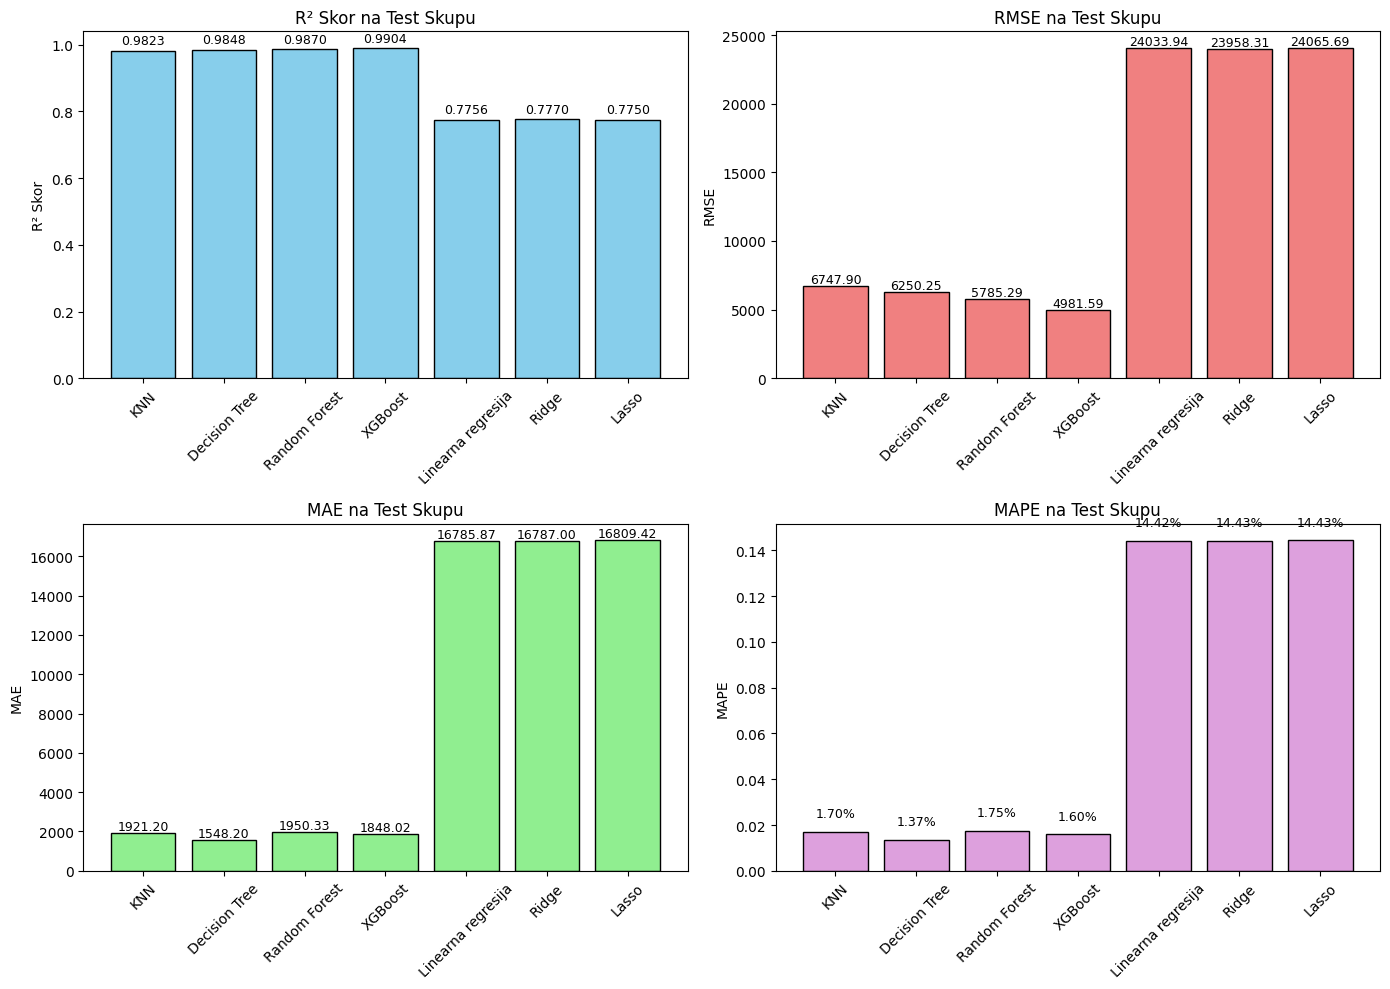


Analiza modela je završena!


In [12]:
import pandas as pd

results = {
    'Model': ['KNN', 'Decision Tree', 'Random Forest', 'XGBoost', 'Linearna regresija', 'Ridge', 'Lasso'],
    'Valid RMSE': [],
    'Valid R²': [],
    'Valid MAE': [],
    'Valid MAPE': [],
    'Test RMSE': [],
    'Test R²': [],
    'Test MAE': [],
    'Test MAPE': []
}

# KNN
y_pred_valid_knn = np.expm1(best_knn.predict(X_valid_scaled))
y_pred_test_knn = np.expm1(best_knn.predict(X_test_scaled))
results['Valid RMSE'].append(mean_squared_error(y_valid, y_pred_valid_knn, squared=False))
results['Valid R²'].append(r2_score(y_valid, y_pred_valid_knn))
results['Valid MAE'].append(mean_absolute_error(y_valid, y_pred_valid_knn))
results['Valid MAPE'].append(mean_absolute_percentage_error(y_valid, y_pred_valid_knn))
results['Test RMSE'].append(mean_squared_error(y_test, y_pred_test_knn, squared=False))
results['Test R²'].append(r2_score(y_test, y_pred_test_knn))
results['Test MAE'].append(mean_absolute_error(y_test, y_pred_test_knn))
results['Test MAPE'].append(mean_absolute_percentage_error(y_test, y_pred_test_knn))

# Decision Tree
y_pred_valid_dt = np.expm1(best_dt.predict(X_valid_scaled))
y_pred_test_dt = np.expm1(best_dt.predict(X_test_scaled))
results['Valid RMSE'].append(mean_squared_error(y_valid, y_pred_valid_dt, squared=False))
results['Valid R²'].append(r2_score(y_valid, y_pred_valid_dt))
results['Valid MAE'].append(mean_absolute_error(y_valid, y_pred_valid_dt))
results['Valid MAPE'].append(mean_absolute_percentage_error(y_valid, y_pred_valid_dt))
results['Test RMSE'].append(mean_squared_error(y_test, y_pred_test_dt, squared=False))
results['Test R²'].append(r2_score(y_test, y_pred_test_dt))
results['Test MAE'].append(mean_absolute_error(y_test, y_pred_test_dt))
results['Test MAPE'].append(mean_absolute_percentage_error(y_test, y_pred_test_dt))

# Random Forest
y_pred_valid_rf = np.expm1(best_rf.predict(X_valid_scaled))
y_pred_test_rf = np.expm1(best_rf.predict(X_test_scaled))
results['Valid RMSE'].append(mean_squared_error(y_valid, y_pred_valid_rf, squared=False))
results['Valid R²'].append(r2_score(y_valid, y_pred_valid_rf))
results['Valid MAE'].append(mean_absolute_error(y_valid, y_pred_valid_rf))
results['Valid MAPE'].append(mean_absolute_percentage_error(y_valid, y_pred_valid_rf))
results['Test RMSE'].append(mean_squared_error(y_test, y_pred_test_rf, squared=False))
results['Test R²'].append(r2_score(y_test, y_pred_test_rf))
results['Test MAE'].append(mean_absolute_error(y_test, y_pred_test_rf))
results['Test MAPE'].append(mean_absolute_percentage_error(y_test, y_pred_test_rf))

# XGBoost
y_pred_valid_xgb = np.expm1(best_xgb.predict(X_valid_scaled))
y_pred_test_xgb = np.expm1(best_xgb.predict(X_test_scaled))
results['Valid RMSE'].append(mean_squared_error(y_valid, y_pred_valid_xgb, squared=False))
results['Valid R²'].append(r2_score(y_valid, y_pred_valid_xgb))
results['Valid MAE'].append(mean_absolute_error(y_valid, y_pred_valid_xgb))
results['Valid MAPE'].append(mean_absolute_percentage_error(y_valid, y_pred_valid_xgb))
results['Test RMSE'].append(mean_squared_error(y_test, y_pred_test_xgb, squared=False))
results['Test R²'].append(r2_score(y_test, y_pred_test_xgb))
results['Test MAE'].append(mean_absolute_error(y_test, y_pred_test_xgb))
results['Test MAPE'].append(mean_absolute_percentage_error(y_test, y_pred_test_xgb))

# Linearna regresija
y_pred_valid_lin = np.expm1(lin_reg.predict(X_valid_scaled))
y_pred_test_lin = np.expm1(lin_reg.predict(X_test_scaled))
results['Valid RMSE'].append(mean_squared_error(y_valid, y_pred_valid_lin, squared=False))
results['Valid R²'].append(r2_score(y_valid, y_pred_valid_lin))
results['Valid MAE'].append(mean_absolute_error(y_valid, y_pred_valid_lin))
results['Valid MAPE'].append(mean_absolute_percentage_error(y_valid, y_pred_valid_lin))
results['Test RMSE'].append(mean_squared_error(y_test, y_pred_test_lin, squared=False))
results['Test R²'].append(r2_score(y_test, y_pred_test_lin))
results['Test MAE'].append(mean_absolute_error(y_test, y_pred_test_lin))
results['Test MAPE'].append(mean_absolute_percentage_error(y_test, y_pred_test_lin))

# Ridge
y_pred_valid_ridge = np.expm1(best_ridge.predict(X_valid_scaled))
y_pred_test_ridge = np.expm1(best_ridge.predict(X_test_scaled))
results['Valid RMSE'].append(mean_squared_error(y_valid, y_pred_valid_ridge, squared=False))
results['Valid R²'].append(r2_score(y_valid, y_pred_valid_ridge))
results['Valid MAE'].append(mean_absolute_error(y_valid, y_pred_valid_ridge))
results['Valid MAPE'].append(mean_absolute_percentage_error(y_valid, y_pred_valid_ridge))
results['Test RMSE'].append(mean_squared_error(y_test, y_pred_test_ridge, squared=False))
results['Test R²'].append(r2_score(y_test, y_pred_test_ridge))
results['Test MAE'].append(mean_absolute_error(y_test, y_pred_test_ridge))
results['Test MAPE'].append(mean_absolute_percentage_error(y_test, y_pred_test_ridge))

# Lasso
y_pred_valid_lasso = np.expm1(best_lasso.predict(X_valid_scaled))
y_pred_test_lasso = np.expm1(best_lasso.predict(X_test_scaled))
results['Valid RMSE'].append(mean_squared_error(y_valid, y_pred_valid_lasso, squared=False))
results['Valid R²'].append(r2_score(y_valid, y_pred_valid_lasso))
results['Valid MAE'].append(mean_absolute_error(y_valid, y_pred_valid_lasso))
results['Valid MAPE'].append(mean_absolute_percentage_error(y_valid, y_pred_valid_lasso))
results['Test RMSE'].append(mean_squared_error(y_test, y_pred_test_lasso, squared=False))
results['Test R²'].append(r2_score(y_test, y_pred_test_lasso))
results['Test MAE'].append(mean_absolute_error(y_test, y_pred_test_lasso))
results['Test MAPE'].append(mean_absolute_percentage_error(y_test, y_pred_test_lasso))

# Kreiraj DataFrame
comparison_df = pd.DataFrame(results)
print("\n" + "="*120)
print("POREĐENJE SVIH MODELA")
print("="*120)
print(comparison_df.to_string())
print("="*120)

print("\nNajbolji modeli po metrikama:")
print(f"Najniži Test RMSE: {comparison_df.loc[comparison_df['Test RMSE'].idxmin(), 'Model']} ({comparison_df['Test RMSE'].min():.2f})")
print(f"Najviši Test R²: {comparison_df.loc[comparison_df['Test R²'].idxmax(), 'Model']} ({comparison_df['Test R²'].max():.4f})")
print(f"Najniži Test MAE: {comparison_df.loc[comparison_df['Test MAE'].idxmin(), 'Model']} ({comparison_df['Test MAE'].min():.2f})")
print(f"Najniži Test MAPE: {comparison_df.loc[comparison_df['Test MAPE'].idxmin(), 'Model']} ({comparison_df['Test MAPE'].min():.2%})")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# R² comparison
axes[0, 0].bar(comparison_df['Model'], comparison_df['Test R²'], color='skyblue', edgecolor='black')
axes[0, 0].set_title('R² Skor na Test Skupu')
axes[0, 0].set_ylabel('R² Skor')
axes[0, 0].tick_params(axis='x', rotation=45)
for i, v in enumerate(comparison_df['Test R²']):
    axes[0, 0].text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom', fontsize=9)

# RMSE comparison
axes[0, 1].bar(comparison_df['Model'], comparison_df['Test RMSE'], color='lightcoral', edgecolor='black')
axes[0, 1].set_title('RMSE na Test Skupu')
axes[0, 1].set_ylabel('RMSE')
axes[0, 1].tick_params(axis='x', rotation=45)
for i, v in enumerate(comparison_df['Test RMSE']):
    axes[0, 1].text(i, v + 10, f'{v:.2f}', ha='center', va='bottom', fontsize=9)

# MAE comparison
axes[1, 0].bar(comparison_df['Model'], comparison_df['Test MAE'], color='lightgreen', edgecolor='black')
axes[1, 0].set_title('MAE na Test Skupu')
axes[1, 0].set_ylabel('MAE')
axes[1, 0].tick_params(axis='x', rotation=45)
for i, v in enumerate(comparison_df['Test MAE']):
    axes[1, 0].text(i, v + 2, f'{v:.2f}', ha='center', va='bottom', fontsize=9)

# MAPE comparison
axes[1, 1].bar(comparison_df['Model'], comparison_df['Test MAPE'], color='plum', edgecolor='black')
axes[1, 1].set_title('MAPE na Test Skupu')
axes[1, 1].set_ylabel('MAPE')
axes[1, 1].tick_params(axis='x', rotation=45)
for i, v in enumerate(comparison_df['Test MAPE']):
    axes[1, 1].text(i, v + 0.005, f'{v:.2%}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\nAnaliza modela je završena!")